In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import datetime as dt
from sklearn import preprocessing
from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("./dataset/train.csv")
print(max(data['Date']))

2020-04-29


In [3]:
data.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


In [4]:
data['Date'] = pd.to_datetime(data['Date'], dayfirst = True)
india_data = data.loc[data['Country_Region'] == 'India']
india_data.head()
india_data = india_data.drop(columns = ['Province_State', 'Fatalities', 'Country_Region'])
india_data.head()

,Id,Date,ConfirmedCases
13860,15961,2020-01-22,0.0
13861,15962,2020-01-23,0.0
13862,15963,2020-01-24,0.0
13863,15964,2020-01-25,0.0
13864,15965,2020-01-26,0.0


In [5]:
le = preprocessing.LabelEncoder()

india_data['Day_num'] = le.fit_transform(india_data.Date)
india_data['Day'] = india_data['Date'].dt.day
india_data['Month'] = india_data['Date'].dt.month
india_data['Year'] = india_data['Date'].dt.year

# india_data['State/UnionTerritory'] = le.fit_transform(india_data['State/UnionTerritory'])
# number_c = india_data['State/UnionTerritory']
# states = le.inverse_transform(india_data['State/UnionTerritory'])
# state_dict = dict(zip(states, number_c))

india_data[['ConfirmedCases']] = india_data[['ConfirmedCases']].astype('float64')
india_data[['ConfirmedCases']] = india_data[['ConfirmedCases']].apply(lambda x: np.log1p(x))
india_data.replace([np.inf, -np.inf], 0, inplace=True)
india_data.head()

,Id,Date,ConfirmedCases,Day_num,Day,Month,Year
13860,15961,2020-01-22,0.0,0,22,1,2020
13861,15962,2020-01-23,0.0,1,23,1,2020
13862,15963,2020-01-24,0.0,2,24,1,2020
13863,15964,2020-01-25,0.0,3,25,1,2020
13864,15965,2020-01-26,0.0,4,26,1,2020


In [6]:
def train_test_split_custom(df, start_day, train_lim, test_lim):
    
    X_train = df.loc[df['Day_num'] <= train_lim]
    X_train = X_train[X_train['Day_num'] > start_day]
    X_test = df.loc[df['Day_num'] <= test_lim]
    X_test = X_test.loc[X_test['Day_num'] > train_lim]
    
    y_train = X_train['ConfirmedCases']
    y_test = X_test['ConfirmedCases']
    
    X_train = X_train.drop(['ConfirmedCases'], axis = 1)
    X_test = X_test.drop(['ConfirmedCases'], axis = 1)
    
    return X_train, y_train, X_test, y_test

In [7]:
X_train, y_train, X_test, y_test = train_test_split_custom(india_data, 20, 80, 99)
X_train.head()

,Id,Date,Day_num,Day,Month,Year
13881,15982,2020-02-12,21,12,2,2020
13882,15983,2020-02-13,22,13,2,2020
13883,15984,2020-02-14,23,14,2,2020
13884,15985,2020-02-15,24,15,2,2020
13885,15986,2020-02-16,25,16,2,2020


In [8]:
def lin_reg(X_train, Y_train, X_test):
    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, Y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)
    
    return regr, y_pred

In [9]:
def plot_country(data, start_date, train_lim, test_lim):
#     state_data = data[data['State/UnionTerritory'] == state_dict[state_name]]
    X_train, y_train, X_test, y_test = train_test_split_custom(data, start_date, train_lim, test_lim)
    print("X_test.shape", X_test.shape)
    print("y_test.shape", y_test.shape)
    X_train['Date']=X_train['Date'].map(dt.datetime.toordinal)
    X_test['Date']=X_test['Date'].map(dt.datetime.toordinal)

    
    model, pred = lin_reg(X_train, y_train, X_test)
    
    plt.plot(X_test['Day_num'], np.expm1(y_test), color = 'blue')
    plt.plot(X_test['Day_num'], np.expm1(pred), color = 'green')
    plt.show()

X_test.shape (18, 6)
y_test.shape (18,)


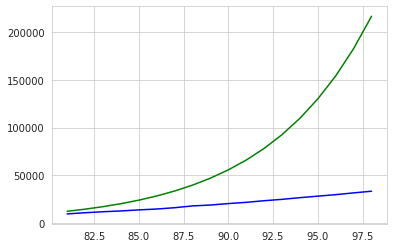

In [10]:
plot_country(india_data, 30, 80, 99)

In [11]:
def calculate_lag(df, lag_list, column):
    for lag in lag_list:
        column_lag = column + "_" + str(lag)
        df[column_lag] = df[column].shift(lag, fill_value=0)
    return df

def calculate_trend(df, lag_list, column):
    for lag in lag_list:
        trend_column_lag = "Trend_" + column + "_" + str(lag)
        df[trend_column_lag] = (df[column].shift(0, fill_value=0) - 
                                df[column].shift(lag, fill_value=0))/df[column].shift(lag, fill_value=0.001)
    return df

In [12]:
def split_data_one_day(df, start_date, d, train_lim, test_lim):
    X_train = df[df['Day_num'] >= start_date]
    X_train = X_train[X_train['Day_num'] < train_lim]
    
    y_train = X_train['ConfirmedCases']
    X_train = X_train.drop(columns = ['ConfirmedCases'])
    X_test = df[df['Day_num'] == d]
    y_test = X_test['ConfirmedCases']
    X_test = X_test.drop(columns = ['ConfirmedCases'])
    
    return X_train, y_train, X_test, y_test

In [13]:
X_train, y_train, X_test, y_test = split_data_one_day(india_data, 60, 81, 80, 90 )


In [32]:
def lin_reg_with_lags_state(dataframe,start_date, lag_size, train_lim, test_lim):
#     state_data = data[data['State/UnionTerritory'] == state_dict[state_name]]
    
    #compute lags
    data = dataframe.copy()
    data = calculate_lag(data, range(1, lag_size), 'ConfirmedCases')
    data = calculate_trend(data, range(1, 8), 'ConfirmedCases')
    data.replace([np.inf, -np.inf], 0, inplace=True)
    data.fillna(0, inplace=True)
    
    tr_lim = train_lim
    ts_lim = test_lim
    y_test_data = []
    y_pred_data = []
    dayd = []
    
    for d in list(range(train_lim, test_lim)):
        X_train, y_train, X_test, y_test = split_data_one_day(data, start_date, d, tr_lim, ts_lim)
        X_train['Date']=X_train['Date'].map(dt.datetime.toordinal)
        X_test['Date']=X_test['Date'].map(dt.datetime.toordinal)
        model, pred = lin_reg(X_train, y_train, X_test)
        print(y_test.values)
        data.loc[data['Day_num'] == d, 'ConfirmedCases'] = pred
        
        data = calculate_lag(data, range(1, lag_size), 'ConfirmedCases')
        data = calculate_trend(data, range(1, 8), 'ConfirmedCases')
        
        y_test_data.append(np.expm1(y_test.values))
        y_pred_data.append(np.expm1(pred))
        dayd.append(d)
        tr_lim += 1
        start_date += 1
        
    return y_pred_data, y_test_data, dayd
    
    
y_pred_data, y_test_data, dayd = lin_reg_with_lags_state(india_data, 50, 15, 90, 99)
        
    


[9.90752937]
[9.96979014]
[10.04663506]
[10.1076929]
[10.17671567]
[10.23605934]
[10.2905171]
[10.35217178]
[10.40617011]


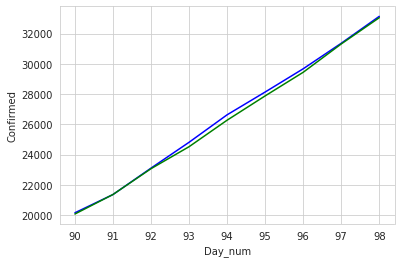

In [33]:
plt.plot(dayd, y_pred_data, color = 'blue')
plt.plot(dayd, y_test_data, color = 'green')
plt.ylabel('Confirmed')
plt.xlabel('Day_num')
plt.show()

In [34]:
def create_df(data, dayCount):
#     state = data['State/UnionTerritory']
#     state = state.values[0]
    lastid = max(data['Id'])
    lastDate = max(data['Date'])
    cols = data.columns
    lastDay_num = max(data['Day_num'])
    lastDay = max(data['Day'])
    
    curr_id = lastid + 1;
    start_date = lastDate + dt.timedelta(days=1)
    curr_day_num = lastDay_num + 1
    curr_day = lastDay + 1
    df = pd.DataFrame(columns = cols)
#     df1 = pd.Series([99999, start_date, state, 0.0, 0.0, 0.0 curr_day_num, curr_day, 3 ], index = cols)
    for i in range(1, dayCount):
        df1 = pd.Series([curr_id, start_date, 0.0, curr_day_num, curr_day, 5, 2020 ], index = cols)  
        df = df.append(df1, ignore_index = True)
        start_date = start_date + dt.timedelta(days = 1)
        curr_day_num += 1
        curr_day += 1
        curr_id += 1
        
    return df

In [35]:
def pred_future_confirmed(data, lag_size, next_days):
#         state_data = data[data['State/UnionTerritory'] == state_dict[state_name]]
        train_lim = max(data['Day_num'])
        extra_data = create_df(data, next_days)
        data = data.append(extra_data)
        test_lim = max(data['Day_num'])
        
        data = calculate_lag(data, range(1, lag_size), 'ConfirmedCases')
        data = calculate_trend(data, range(1, 8), 'ConfirmedCases')
        data.replace([np.inf, -np.inf], 0, inplace=True)
        data.fillna(0, inplace=True)
        
        tr_lim = train_lim
        ts_lim = test_lim
        y_test_data = []
        y_pred_data = []
        dayd = []
        start_date = train_lim - 12
        
        
        
        for d in list(range(train_lim, test_lim)):
#             print('start_date = ', start_date, ' d = ', d, ' tr_lim = ', tr_lim,)
            X_train, y_train, X_test, y_test = split_data_one_day(data, start_date, d, tr_lim, ts_lim)
#             print(X_test.columns)
            X_train['Date']=X_train['Date'].map(dt.datetime.toordinal)
            X_test['Date']=X_test['Date'].map(dt.datetime.toordinal)
            model, pred = lin_reg(X_train, y_train, X_test)
#             print((pred))
            data.loc[data['Day_num'] == d , 'ConfirmedCases'] = pred
#             print(state_data.loc[state_data['Day_num'] == d])
#             state_data.loc[state_data['Day_num'] == d] = calculate_lag(state_data.loc[state_data['Day_num'] == d], range(1, lag_size), 'Confirmed')
#             state_data.loc[state_data['Day_num'] == d] = calculate_trend(state_data.loc[state_data['Day_num'] == d], range(1, 8), 'Confirmed')
            data = calculate_lag(data, range(1, lag_size), 'ConfirmedCases')
            data = calculate_trend(data, range(1, 8), 'ConfirmedCases')
#             print(state_data.loc[state_data['Day_num'] == d, 'Confirmed'])
            y_test_data.append(np.expm1(y_test.values))
            y_pred_data.append(np.expm1(pred))
            dayd.append(d)
            tr_lim += 1
            start_date += 1
        
        return y_pred_data, y_test_data, dayd


In [36]:
y_pred_next, y_test_next, dayd_next = pred_future_confirmed(india_data, 40, 15)

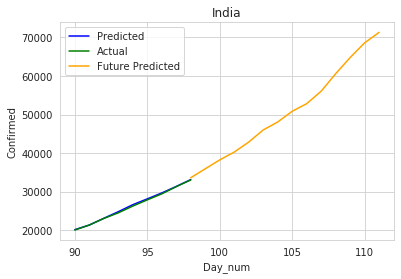

In [38]:
plt.plot(dayd, y_pred_data, color = 'blue', label = 'Predicted')
plt.plot(dayd, y_test_data, color = 'green',label = 'Actual')
plt.plot(dayd_next, y_pred_next, color = 'orange', label = 'Future Predicted')
plt.legend(loc = 'upper left')
plt.ylabel('Confirmed')
plt.xlabel('Day_num')
plt.title('India')
plt.show()

In [20]:
spain_data = data.loc[data['Country_Region'] == 'Spain']
spain_data.head()
spain_data = spain_data.drop(columns = ['Province_State', 'Fatalities', 'Country_Region'])
spain_data.head()
le = preprocessing.LabelEncoder()

spain_data['Day_num'] = le.fit_transform(spain_data.Date)
spain_data['Day'] = spain_data['Date'].dt.day
spain_data['Month'] = spain_data['Date'].dt.month
spain_data['Year'] = spain_data['Date'].dt.year

# spain_data['State/UnionTerritory'] = le.fit_transform(spain_data['State/UnionTerritory'])
# number_c = spain_data['State/UnionTerritory']
# states = le.inverse_transform(spain_data['State/UnionTerritory'])
# state_dict = dict(zip(states, number_c))

spain_data[['ConfirmedCases']] = spain_data[['ConfirmedCases']].astype('float64')
spain_data[['ConfirmedCases']] = spain_data[['ConfirmedCases']].apply(lambda x: np.log1p(x))
spain_data.replace([np.inf, -np.inf], 0, inplace=True)
spain_data.head()

,Id,Date,ConfirmedCases,Day_num,Day,Month,Year
21978,25309,2020-01-22,0.0,0,22,1,2020
21979,25310,2020-01-23,0.0,1,23,1,2020
21980,25311,2020-01-24,0.0,2,24,1,2020
21981,25312,2020-01-25,0.0,3,25,1,2020
21982,25313,2020-01-26,0.0,4,26,1,2020


[12.22675234]
[12.2471666]
[12.26916481]
[12.30031407]
[12.31832933]
[12.33107401]
[12.34332274]
[12.35504853]
[12.37539339]


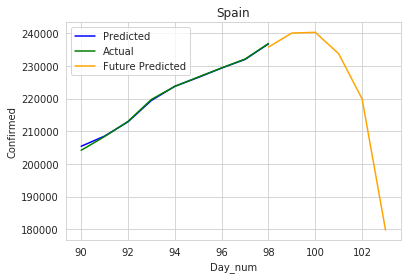

In [44]:
y_pred_data, y_test_data, dayd = lin_reg_with_lags_state(spain_data, 50, 15, 90, 99)
y_pred_next, y_test_next, dayd_next = pred_future_confirmed(spain_data, 40, 7)
plt.plot(dayd, y_pred_data, color = 'blue', label = 'Predicted')
plt.plot(dayd, y_test_data, color = 'green', label = 'Actual')
plt.plot(dayd_next, y_pred_next, color = 'orange', label = 'Future Predicted')
plt.legend(loc = 'bottom left')
plt.ylabel('Confirmed')
plt.xlabel('Day_num')
plt.title('Spain')
plt.show()

In [31]:
SK_data = data.loc[data['Country_Region'] == 'Korea, South']
SK_data.head()
SK_data = SK_data.drop(columns = ['Province_State', 'Fatalities', 'Country_Region'])
SK_data.head()
le = preprocessing.LabelEncoder()

SK_data['Day_num'] = le.fit_transform(SK_data.Date)
SK_data['Day'] = SK_data['Date'].dt.day
SK_data['Month'] = SK_data['Date'].dt.month
SK_data['Year'] = SK_data['Date'].dt.year

# SK_data['State/UnionTerritory'] = le.fit_transform(SK_data['State/UnionTerritory'])
# number_c = SK_data['State/UnionTerritory']
# states = le.inverse_transform(SK_data['State/UnionTerritory'])
# state_dict = dict(zip(states, number_c))

SK_data[['ConfirmedCases']] = SK_data[['ConfirmedCases']].astype('float64')
SK_data[['ConfirmedCases']] = SK_data[['ConfirmedCases']].apply(lambda x: np.log1p(x))
SK_data.replace([np.inf, -np.inf], 0, inplace=True)
SK_data.head()

,Id,Date,ConfirmedCases,Day_num,Day,Month,Year
15048,17329,2020-01-22,0.693147,0,22,1,2020
15049,17330,2020-01-23,0.693147,1,23,1,2020
15050,17331,2020-01-24,1.098612,2,24,1,2020
15051,17332,2020-01-25,1.098612,3,25,1,2020
15052,17333,2020-01-26,1.386294,4,26,1,2020


[9.27650257]
[9.27753162]
[9.27883979]
[9.27977315]
[9.28070563]
[9.28163725]
[9.28294006]
[9.28377669]
[9.2841483]


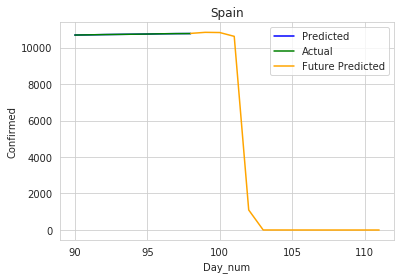

In [41]:
y_pred_data, y_test_data, dayd = lin_reg_with_lags_state(SK_data, 50, 15, 90, 99)
y_pred_next, y_test_next, dayd_next = pred_future_confirmed(SK_data, 40, 15)
plt.plot(dayd, y_pred_data, color = 'blue', label = 'Predicted')
plt.plot(dayd, y_test_data, color = 'green', label = 'Actual')
plt.plot(dayd_next, y_pred_next, color = 'orange', label = 'Future Predicted')
plt.legend(loc = 'upper right')
plt.ylabel('Confirmed')
plt.xlabel('Day_num')
plt.title('Spain')
plt.show()